In [1]:
import pandas as pd
import networkx as nx
print(nx.__version__)
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from utils import *
from plot_utils import *
from metrics import *

import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

2.5


# Load Dataset

In [415]:
data_download()

Download completed


In [416]:
#specifica country, base è italy
match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team = load_public_dataset(data_folder=data_folder, tournament = 'Italy')

In [473]:
match_id = 2576105 # a single match in Italy
match_events = match_id2events[match_id]
match_label = match_id2match[match_id]['label']
            
match_df = pd.DataFrame(match_events)

#prova un team
match_df1 = match_df[match_df['teamId'] == 3187]

match_df1['x_start'] = [x[0]['x'] for x in match_df1['positions']]
match_df1['y_start'] = [x[0]['y'] for x in match_df1['positions']]
match_df1.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x_start,y_start
2,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",40726,"[{'y': 59, 'x': 28}, {'y': 54, 'x': 25}]",2576105,Duel,3187,1H,6.787307,13,210904066,28,59
4,1,Air duel,"[{'id': 703}, {'id': 1801}]",3300,"[{'y': 54, 'x': 25}, {'y': 69, 'x': 30}]",2576105,Duel,3187,1H,7.423298,10,210904067,25,54
9,1,Ground attacking duel,"[{'id': 701}, {'id': 1802}]",21385,"[{'y': 23, 'x': 35}, {'y': 27, 'x': 40}]",2576105,Duel,3187,1H,14.085138,11,210904070,35,23
17,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",25726,"[{'y': 39, 'x': 40}, {'y': 47, 'x': 45}]",2576105,Duel,3187,1H,34.051004,13,210904073,40,39
19,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",25726,"[{'y': 47, 'x': 45}, {'y': 50, 'x': 45}]",2576105,Duel,3187,1H,35.541999,11,210904074,45,47


In [474]:
match_id = 2576105 # a single match in Italy
match_events = match_id2events[match_id]
match_label = match_id2match[match_id]['label']
            
match_df = pd.DataFrame(match_events)

#prova un team
match_df2 = match_df[match_df['teamId'] == 3159]

match_df2['x_start'] = [x[0]['x'] for x in match_df2['positions']]
match_df2['y_start'] = [x[0]['y'] for x in match_df2['positions']]
match_df2.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x_start,y_start
0,8,Simple pass,[{'id': 1801}],89186,"[{'y': 49, 'x': 51}, {'y': 51, 'x': 30}]",2576105,Pass,3159,1H,1.306695,85,210903987,51,49
1,8,High pass,[{'id': 1801}],20461,"[{'y': 51, 'x': 30}, {'y': 41, 'x': 72}]",2576105,Pass,3159,1H,4.250663,83,210903988,30,51
3,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",25437,"[{'y': 41, 'x': 72}, {'y': 46, 'x': 75}]",2576105,Duel,3159,1H,7.329948,13,210903989,72,41
5,1,Air duel,"[{'id': 701}, {'id': 1802}]",0,"[{'y': 46, 'x': 75}, {'y': 31, 'x': 70}]",2576105,Duel,3159,1H,7.423298,10,210906034,75,46
6,8,Simple pass,[{'id': 1801}],3323,"[{'y': 31, 'x': 70}, {'y': 42, 'x': 69}]",2576105,Pass,3159,1H,9.752205,85,210903990,70,31


In [475]:
#DIZIONARIO player:posizione media
avg_position = round(match_df1.groupby('playerId')['x_start','y_start'].mean(), 2)
avg_position['pos'] = list(zip(avg_position.x_start, avg_position.y_start)) 
avg_position.drop(['x_start', 'y_start'], axis = 1, inplace=True)
avg_position['playerId'] = avg_position.index
avg_position = dict(zip(avg_position.playerId, avg_position.pos))

In [476]:
avg = {}
for node, pos in avg_position.items():
    if node == 0:
        pass
    else:
        avg[player_id2player[node]['shortName'].encode('ascii', 'strict').decode('unicode-escape')] = pos

In [477]:
#dizionario nome giocatore : posizione media
avg

{'D. Mertens': (75.81, 48.48),
 'Albiol': (47.23, 66.62),
 'José Callejón': (73.24, 62.8),
 'Pepe Reina': (9.04, 38.6),
 'E. Hysaj': (58.99, 76.99),
 'M. Hamšík': (63.98, 36.44),
 'C. Maggio': (64.78, 88.9),
 'Jorginho': (57.97, 52.24),
 'L. Insigne': (72.36, 24.49),
 'Mário Rui': (66.6, 13.87),
 'K. Koulibaly': (47.95, 33.77),
 'Allan': (61.9, 70.47),
 'P. Zieliński': (68.09, 73.09),
 'A. Ounas': (78.44, 88.3)}

In [478]:
avg_position2 = round(match_df2.groupby('playerId')['x_start','y_start'].mean(), 2)
avg_position2['pos'] = list(zip(avg_position2.x_start, avg_position2.y_start)) 
avg_position2.drop(['x_start', 'y_start'], axis = 1, inplace=True)
avg_position2['playerId'] = avg_position2.index
avg_position2 = dict(zip(avg_position2.playerId, avg_position2.pos))

In [479]:
avg2 = {}
for node, pos in avg_position2.items():
    if node == 0:
        pass
    else:
        avg2[player_id2player[node]['shortName'].encode('ascii', 'strict').decode('unicode-escape')] = pos

In [480]:
avg2

{'S. Khedira': (38.89, 69.32),
 'G. Higuaín': (52.35, 49.3),
 'M. De Sciglio': (25.58, 83.39),
 'M. Pjanić': (39.88, 47.13),
 'G. Buffon': (48.02, 71.45),
 'A. Barzagli': (31.67, 78.33),
 'G. Chiellini': (24.97, 29.63),
 'C. Marchisio': (16.33, 54.33),
 'M. Benatia': (20.46, 65.8),
 'K. Asamoah': (32.79, 12.45),
 'J. Cuadrado': (44.0, 87.75),
 'B. Matuidi': (47.2, 18.04),
 'P. Dybala': (44.69, 51.02),
 'Douglas Costa': (46.06, 83.61)}

# Graph

In [481]:
def passing_networks(match_id=2576105):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split('-')[0].split(' ')[0]
    team2_name = match_label.split('-')[1].split(' ')[1].split(',')[0]
    
    # take all the events of the match
    match_events = []
    for event in match_id2events[match_id]:
        if event['eventName'] == 'Pass':
            match_events.append(event)

    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])

    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration
    
    team2pass2weight = defaultdict(lambda: defaultdict(int))
    send = []
    receive = []
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and ACCURATE_PASS in [tag['id'] for tag in event['tags']]:
                sender = player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                send.append(sender)
                # case of duel
                if next_event['eventName'] == 'Duel':
                    # if the next event of from a playero of the same tema
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                        receive.append(receive)
                    else:
                        receiver = player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                        receive.append(receive)
                else:  # any other event 
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                        receive.append(receive)
        except KeyError:
            pass
    # craete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    
    
    return G1, G2

In [488]:
#controlla versionen NX
for node, pos in avg.items(): #Add Node positions
    G1.nodes[node] = node

TypeError: 'NodeView' object does not support item assignment

In [483]:
nx.get_node_attributes(G1, pos)

{'A. Ounas': (78.44, 88.3)}

In [461]:
for node, pos in avg2.items(): #Add Node positions
    G2.nodes[node][pos] = pos

S. Khedira
G. Higuaín
M. De Sciglio
M. Pjanić
G. Buffon
A. Barzagli
G. Chiellini
C. Marchisio
M. Benatia
K. Asamoah
J. Cuadrado
B. Matuidi
P. Dybala
Douglas Costa


In [460]:
nx.get_node_attributes(G2, pos)

{'Douglas Costa': (46.06, 83.61)}

In [456]:
def plot_passing_networks(G1, G2):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """
    #fig, ax = pitch_graph_zone()
    
    #pos1 = nx.spring_layout(G1, 4)
    #pos2 = nx.spring_layout(G2, 4)
    nome2degree = dict(G1.degree)
    nx.draw(G1, pos = avg1, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()
    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos = avg2, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()

In [457]:
nome2degree = dict(G1.degree)

nx.draw(G1, pos = G1[pos], nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
plt.show()

KeyError: (78.44, 88.3)

In [434]:
pos = nx.get_node_attributes(G1,'pos')
pos

{}

In [431]:
G1[pos]

KeyError: (46.06, 83.61)

In [399]:
nx.get_node_attributes(G1,'pos')

{'K. Koulibaly': (47.95, 33.77),
 'Allan': (61.9, 70.47),
 'D. Mertens': (75.81, 48.48),
 'M. Hamšík': (63.98, 36.44),
 'L. Insigne': (72.36, 24.49),
 'Mário Rui': (66.6, 13.87),
 'Jorginho': (57.97, 52.24),
 'Pepe Reina': (9.04, 38.6),
 'Albiol': (47.23, 66.62),
 'E. Hysaj': (58.99, 76.99),
 'José Callejón': (73.24, 62.8),
 'P. Zieliński': (68.09, 73.09),
 'C. Maggio': (64.78, 88.9),
 'A. Ounas': (78.44, 88.3)}

In [397]:
nx.get_node_attributes(G2,'pos')

{'P. Dybala': (44.69, 51.02),
 'G. Chiellini': (24.97, 29.63),
 'G. Higuaín': (52.35, 49.3),
 'M. Pjanić': (39.88, 47.13),
 'S. Khedira': (38.89, 69.32),
 'M. De Sciglio': (25.58, 83.39),
 'K. Asamoah': (32.79, 12.45),
 'M. Benatia': (20.46, 65.8),
 'G. Buffon': (48.02, 71.45),
 'Douglas Costa': (46.06, 83.61),
 'B. Matuidi': (47.2, 18.04),
 'C. Marchisio': (16.33, 54.33),
 'J. Cuadrado': (44.0, 87.75),
 'A. Barzagli': (31.67, 78.33)}

In [401]:
G1, G2 = passing_networks(match_id=2576105)

NetworkXError: Node 'K. Koulibaly' has no position.

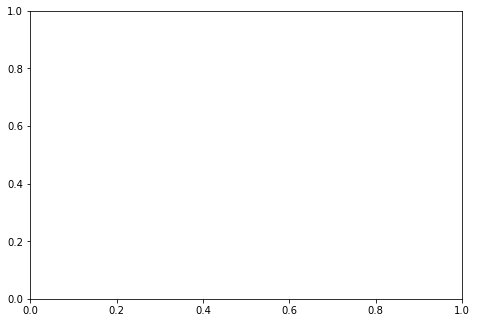

In [402]:
plot_passing_networks(G1, G2)